# Simple Growth Model
### Evan Edwards

- Simple growth model with set parameters using the following error metrics:
    - RMSE
    - R^2
    - D^2
- Optimization (Work in Progress)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import numpy as np
from sklearn.metrics import mean_squared_error, d2_absolute_error_score, r2_score
from sklearn.model_selection import train_test_split
import arviz as az
import scipy as sp
import time
from scipy.optimize import minimize

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
ECLSK2011 = pd.read_csv('ECLSK2011.csv')
ECLSK2011 = ECLSK2011.dropna(axis=1, how='all')
missing_math_rows = ECLSK2011[ECLSK2011.groupby('CHILDID')['MATH'].transform(lambda x: any(x.isna()))]

ECLSK2011 = ECLSK2011.drop(missing_math_rows.index)



In [5]:
ECLSK2011_train, ECLSK2011_test = train_test_split(ECLSK2011, test_size=0.1)

In [4]:

# Level 1

#std_y_ti | pi_0i, pi_1i, pi_2i, sigma ~ normal(pi_0i + pi_1i  (X1)+ pi_2i (X2), sigma^2) 
# pi_0i | beta00, sigma00 ~ normal(beta00, sigma00^2)
# pi_1i | beta10, sigma01 ~ normal(beta10, sigma10^2)
# pi_2i | beta20, sigma02 ~ normal(beta20, sigma20^2)
# sigma^2 ~ inv_gamma(nu/2, nu * lambda/2)

# Level 2
# beta00 ~ N(0, tau00^2)
# beta10 ~ N(0, tau10^2)
# beta20 ~ N(0, tau20^2)

#sigma00 = sigma10 = sigma = .3
#tau00 = tau10 = tau20 = .4


In [6]:
'''
# Level 1 priors
sigma00 = sigma10 = sigma20 = 0.3

# Level 2 priors
tau00 = tau10 = tau20 = 0.4

nu = 3
lamb = 0.194
'''

# Level 1 priors
sigma00 = sigma10 = sigma20 = 0.3

# Level 2 priors
tau00 = tau10 = tau20 = 0.4

nu = 3
lamb = 0.194

std_y_ti_data = sp.stats.zscore(ECLSK2011_train['MATH'])
time_data = ECLSK2011_train['TIME']
start_time = time.time()
with pm.Model() as model:
    std_y_ti_data = pm.MutableData("std_y_ti_data", std_y_ti_data)
    time_data = pm.MutableData("time_data", time_data)
    

    beta00 = pm.Normal('beta00', mu=0, sigma=tau00**2)
    beta10 = pm.Normal('beta10', mu=0, sigma=tau10**2)
    beta20 = pm.Normal('beta20', mu=0, sigma=tau20**2)

    pi_0i = pm.Normal('pi_0i', mu=beta00, sigma=sigma00**2)
    pi_1i = pm.Normal('pi_1i', mu=beta10, sigma=sigma10**2)
    pi_2i = pm.Normal('pi_2i', mu=beta20, sigma=sigma20**2)
    
    sigma_sq = pm.InverseGamma('sigma_sq', alpha=nu/2, beta=nu*lamb/2)
    T_ti = time_data
    T_ti_hat = pm.math.mean(time_data)


    #Taylor Series
    X1 = T_ti - T_ti_hat
    X2 = (X1**2)/2

    std_y_ti = pm.Normal('std_y_ti', mu=pi_0i + pi_1i*(X1) + pi_2i*(X2), sigma=sigma_sq, observed=std_y_ti_data)

    trace = pm.sample(2000, tune=1000)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Computation time: {elapsed_time} seconds")
pm.summary(trace,hdi_prob = 0.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta00, beta10, beta20, pi_0i, pi_1i, pi_2i, sigma_sq]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 105 seconds.


Computation time: 145.8975043296814 seconds


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta00,0.020,0.078,-0.131,0.171,0.001,0.001,11467.0,5944.0,1.0
beta10,0.254,0.080,0.101,0.409,0.001,0.001,12561.0,6130.0,1.0
beta20,-0.006,0.078,-0.156,0.146,0.001,0.001,12068.0,5847.0,1.0
pi_0i,0.027,0.005,0.018,0.036,0.000,0.000,8871.0,5409.0,1.0
pi_1i,0.334,0.001,0.332,0.337,0.000,0.000,12183.0,6364.0,1.0
pi_2i,-0.008,0.001,-0.010,-0.006,0.000,0.000,8830.0,6219.0,1.0
sigma_sq,0.503,0.002,0.499,0.508,0.000,0.000,11906.0,5635.0,1.0


In [7]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, model=model)
pred = post_pred.posterior_predictive["std_y_ti"].mean(dim=["chain", "draw"])

print(f'The RMSE (IS) is: {np.sqrt(mean_squared_error(sp.stats.zscore(ECLSK2011_train["MATH"]), pred))}')
print(f'The D^2 Absolute Error Score (IS) is: {d2_absolute_error_score(sp.stats.zscore(ECLSK2011_train["MATH"]), pred)}')
print(f'The R^2 (IS) is: {r2_score(sp.stats.zscore(ECLSK2011_train["MATH"]), pred)}')
hdi = az.hdi(post_pred.posterior_predictive, hdi_prob=0.95)
print(f"Mean upper and lower bounds of the 95% CI: {np.mean(np.array(hdi.to_array().sel(hdi='lower'))).astype(float)} - {np.mean(np.array(hdi.to_array().sel(hdi='higher'))).astype(float)}")

with model:
    pm.set_data({"std_y_ti_data": sp.stats.zscore(ECLSK2011_test['MATH']), "time_data": ECLSK2011_test['TIME']}) 
    post_pred = pm.sample_posterior_predictive(trace, model=model)
pred = post_pred.posterior_predictive["std_y_ti"].mean(dim=["chain", "draw"])

print(f'The RMSE (OOS) is: {np.sqrt(mean_squared_error(sp.stats.zscore(ECLSK2011_test["MATH"]), pred))}')
print(f'The D^2 Absolute Error Score (OOS) is: {d2_absolute_error_score(sp.stats.zscore(ECLSK2011_test["MATH"]), pred)}')
print(f'The R^2 (OOS) is: {r2_score(sp.stats.zscore(ECLSK2011_test["MATH"]), pred)}')
hdi = az.hdi(post_pred.posterior_predictive, hdi_prob=0.95)
print(f"Mean upper and lower bounds of the 95% CI: {np.mean(np.array(hdi.to_array().sel(hdi='lower'))).astype(float)} - {np.mean(np.array(hdi.to_array().sel(hdi='higher'))).astype(float)}")



Sampling: [std_y_ti]


The RMSE (IS) is: 0.5033113284868574
The D^2 Absolute Error Score (IS) is: 0.5291954390126088
The R^2 (IS) is: 0.7466777066167947


Sampling: [std_y_ti]


Mean upper and lower bounds of the 95% CI: -0.9827651525101917 - 0.9827506769006263


The RMSE (OOS) is: 0.5048296644077688
The D^2 Absolute Error Score (OOS) is: 0.5298571092616738
The R^2 (OOS) is: 0.7451470099339395
Mean upper and lower bounds of the 95% CI: -0.9825081712077832 - 0.9832341771264684


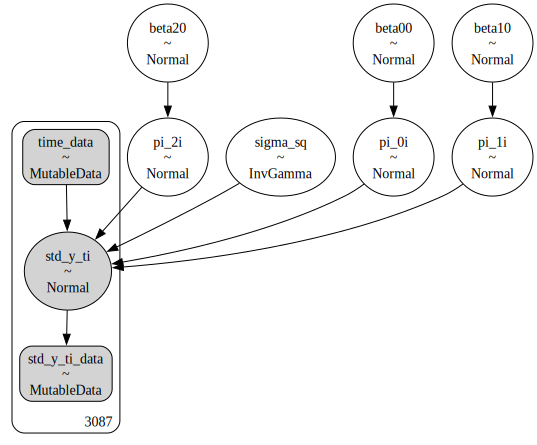

In [8]:
pm.model_to_graphviz(model)

In [15]:
#Optimizing hyperparameters for in sample predictions

import logging
from skopt import gp_minimize
from skopt.space import Real, Integer
RANDOM_SEED = 9572404

# Defining to disable output later for ease of visibility
logger = logging.getLogger("pymc")
# Disabling sampling messages
logger.setLevel(logging.ERROR)

def objective(params):
    sigma = params[0]
    tau = params[1]
    nu = params[2]
    lamb = params[3]
    sigma00 = sigma10 = sigma20 = sigma
    tau00 = tau10 = tau20 = tau
    nu = nu
    lamb = lamb

    
    with pm.Model() as model:
        y_ti_data = ECLSK2011_train['MATH']
        time_data = ECLSK2011_train['TIME']
        

        beta00 = pm.Normal('beta00', mu=0, sigma=tau00**2)
        beta10 = pm.Normal('beta10', mu=0, sigma=tau10**2)
        beta20 = pm.Normal('beta20', mu=0, sigma=tau20**2)

        pi_0i = pm.Normal('pi_0i', mu=beta00, sigma=sigma00**2)
        pi_1i = pm.Normal('pi_1i', mu=beta10, sigma=sigma10**2)
        pi_2i = pm.Normal('pi_2i', mu=beta20, sigma=sigma20**2)
        
        sigma_sq = pm.InverseGamma('sigma_sq', alpha=nu/2, beta=nu*lamb/2)
        T_ti = time_data
        T_ti_hat = np.mean(time_data)


        #Taylor Series
        X1 = T_ti - T_ti_hat
        X2 = (X1**2)/2

        y_ti = pm.Normal('y_ti', mu=pi_0i + pi_1i*(X1) + pi_2i*(X2), sigma=sigma_sq, observed=y_ti_data)

        trace =  pm.sample(2000, tune=1000, random_seed=RANDOM_SEED, progressbar=False)
    with model:
        post_pred = pm.sample_posterior_predictive(trace, model=model, random_seed=RANDOM_SEED, progressbar=False)
    pred = post_pred.posterior_predictive["y_ti"].mean(dim=["chain", "draw"])
    rmse = mean_squared_error((ECLSK2011_train["MATH"]), pred)
    return rmse




space  = [Real(0.1, 10, name='sigma'),
          Real(0.1, 10, name='tau'),
          Real(0.1, 10, name='nu'),
          Real(0.1, 10, name='lambda')]


start_time = time.time()
result = minimize(objective, [0.3, 0.4, 3, 0.194], method="Nelder-Mead", options= {'disp': True, 'return_all':True })
#res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Computation time: {elapsed_time} seconds")
print(result)


Computation time: 6082.444833040237 seconds
          fun: 248.11424889691548
            x: [6.2732805981811275, 3.9053789021977297, 3.045592604790276, 0.6614584754426877]
    func_vals: [ 2.481e+02  2.481e+02 ...  2.481e+02  2.481e+02]
      x_iters: [[5.969161720427683, 8.458230910952073, 8.593661614465294, 8.487792213962845], [6.2732805981811275, 3.9053789021977297, 3.045592604790276, 0.6614584754426877], [2.7992973163431216, 4.828884661481364, 8.140470414877385, 4.851774006513068], [3.9885694813982155, 8.37717975902004, 3.4402219881309577, 6.516901533306854], [3.745591244421426, 9.57583607363516, 1.4894727260851874, 8.713863857748523], [4.788719648209734, 8.029016444598481, 5.252727047556928, 6.820907348177708], [7.234263281786577, 5.861995941543562, 5.419994971545207, 7.6102946807913385], [1.1484853111591424, 4.788644151531909, 1.9446901989349241, 7.3954899535766865], [2.2438485088012823, 1.4386599167139758, 3.3089959771528203, 1.5817811851184638], [2.3009817436907185, 3.92624091